In [1]:
# %%
# Import the necessary libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
from perlin_noise import PerlinNoise
import netCDF4
from IPython.display import clear_output
from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

def print_peak_gpu_memory():
    peak_memory = torch.cuda.max_memory_allocated() / (1024 ** 2)  # in MB
    print(f"Peak GPU memory used: {peak_memory:.2f} MB.")
    torch.cuda.reset_peak_memory_stats()  # Reset after printing

def print_gpu_utilization():
    nvmlInit()  # Initialize NVML
    handle = nvmlDeviceGetHandleByIndex(0)  # Assuming we're using GPU 0
    info = nvmlDeviceGetMemoryInfo(handle)  # Get memory info
    print(f"GPU memory occupied: {info.used // 1024**2} MB.")

# Function to create a 2D smooth random ELA field
def generate_and_plot_ELA_field(Z_topo, Z_ELA, ELA_range=200, octaves=4, seed=42, device='cpu'):
    # Get the dimensions of Z_topo
    height, width = Z_topo.shape

    # Initialize Perlin noise
    noise = PerlinNoise(octaves=octaves, seed=seed)

    # Generate a 2D noise field
    noise_field = torch.tensor(
        [[noise([i / height, j / width]) for j in range(width)] for i in range(height)],
        dtype=torch.bfloat16, device=device
    )

    # Normalize the noise field to be between -1 and 1
    min_noise = torch.min(noise_field)
    max_noise = torch.max(noise_field)
    normalized_noise = 2 * (noise_field - min_noise) / (max_noise - min_noise) - 1

    # Scale the noise to the range [Z_ELA - ELA_range, Z_ELA + ELA_range]
    ELA_field = Z_ELA + ELA_range * normalized_noise

    return ELA_field
def visualize(Z_surf, time, H_ice, Lx, Ly):
    clear_output(wait=True)  # Clear the previous output in the notebook
    plt.figure(2, figsize=(11, 4), dpi=200)

    # Convert tensors to float32 for NumPy compatibility
    Z_surf_np = Z_surf.to(torch.float32).cpu().numpy()
    H_ice_np = H_ice.to(torch.float32).cpu().numpy()

    # First subplot: Ice surface
    plt.subplot(1, 2, 1)
    plt.imshow(Z_surf_np, extent=[0, Lx / 1000, 0, Ly / 1000], cmap='terrain', origin='lower')
    plt.colorbar(label='Elevation (m)')
    plt.title('Ice Surface at ' + str(int(time)) + ' y')
    plt.xlabel('Distance, km')
    plt.ylabel('Distance, km')

    # Second subplot: Ice thickness
    plt.subplot(1, 2, 2)
    plt.imshow(np.where(H_ice_np > 0, H_ice_np, np.nan), extent=[0, Lx / 1000, 0, Ly / 1000], cmap='jet', origin='lower')
    plt.colorbar(label='Ice Thickness (m)')
    plt.title('Ice Thickness at ' + str(int(time)) + ' y')
    plt.xlabel('Distance, km')
    plt.ylabel('Distance, km')

    # Show the plot
    plt.show()


# Prepare hooks for tensors 
def print_hook_b(grad):
    print("\n db/dELA:", torch.mean(grad))
    return grad

def reduce_hook(grad):
    return grad * 0.9

cuda


In [3]:
nc_file = netCDF4.Dataset('bedrock.nc')
Z_topo = torch.tensor(nc_file.variables['topg'][:], device=device, dtype=torch.bfloat16)
ttot = 400  # Time limit (yr)
grad_b = torch.tensor(0.001, dtype=torch.bfloat16, device=device)  # Mass balance gradient
b_max = torch.tensor(0.5, dtype=torch.bfloat16, device=device)  # Maximum precip (m/yr)
Z_ELA = torch.tensor(2000.0, dtype=torch.bfloat16, device=device)  # Elevation of equilibrium line altitude (m)

# Generate and plot the ELA field
# Z_ELA = generate_and_plot_ELA_field(Z_topo, ELA, device=device)
rho, g, fd = torch.tensor([910.0, 9.81, 1e-18], dtype=torch.bfloat16, device=device)

In [4]:
def solve_glacier_dynamics(Z_topo, ttot, grad_b, b_max, Z_ELA, rho=rho, g=g, fd=fd, Lx=902000, Ly=602000, dx=2000, dy=2000, dtmax=1, device=device):
    """
    Solve the glacier dynamics using a diffusion-based solver with PyTorch.
    """
    nx = int(Lx / dx)
    ny = int(Ly / dy)
    
    epsilon = torch.tensor(1.e-20, dtype=torch.bfloat16, device=device)

    # Initialize ice thickness and surface
    H_ice = torch.zeros((ny, nx), device=device, dtype=torch.float32)
    Z_surf = Z_topo + H_ice

    time = torch.tensor(0., dtype=torch.float32, device=device) 
    dt = torch.tensor(dtmax, dtype=torch.bfloat16, device=device)
    it=0

    while time < ttot:

        time += dt
        it += 1
        # Compute H_avg
        H_avg = 0.25 * (H_ice[:-1, :-1] + H_ice[1:, 1:] + H_ice[:-1, 1:] + H_ice[1:, :-1])
  

        # Compute Snorm
        Sx = (Z_surf[:, 1:] - Z_surf[:, :-1]) / dx
        Sy = (Z_surf[1:, :] - Z_surf[:-1, :]) / dy
        Sx = 0.5 * (Sx[:-1, :] + Sx[1:, :])
        Sy = 0.5 * (Sy[:, :-1] + Sy[:, 1:])
        Snorm = torch.sqrt(Sx**2 + Sy**2 +epsilon)

        # Compute diffusivity
        # Perform high-precision computation for stability


        D = fd * (rho * g)**3.0 * H_avg**5 * Snorm**2 + epsilon
        # Compute adaptive time step
        dt = min(min(dx, dy)**2 / (2.7 * torch.max(D).item()), dtmax)


        # Compute fluxes
        qx = -(0.5 * (D[:-1, :] + D[1:, :])) * (Z_surf[1:-1, 1:] - Z_surf[1:-1, :-1]) / dx
        qy = -(0.5 * (D[:, :-1] + D[:, 1:])) * (Z_surf[1:, 1:-1] - Z_surf[:-1, 1:-1]) / dy

        # Compute thickness change rate
        dHdt = -(torch.diff(qx, dim=1) / dx + torch.diff(qy, dim=0) / dy)

        # Update ice thickness
        H_ice[1:-1, 1:-1] += dt * dHdt

        # Compute surface mass balance (SMB)
        b = torch.minimum(grad_b * (Z_surf - Z_ELA), b_max)
        # b.retain_grad()
        # b.register_hook(reduce_hook)

        H_ice[1:-1, 1:-1] += dt * b[1:-1, 1:-1]

        # Ensure ice thickness remains positive
        H_ice = torch.maximum(H_ice, torch.tensor(0.0, dtype=torch.float32, device=device))

        # Update surface topography
        Z_surf = Z_topo + H_ice
     

        # # Visualization at specified intervals
        # if it % 100 == 0:
        #     visualize(Z_surf,time,H_ice,Lx,Ly)
   

    return H_ice , it



In [5]:
Z_ELA = torch.full(Z_topo.shape,2000., requires_grad=True, device=device)
h,it=solve_glacier_dynamics(Z_topo, ttot, grad_b, b_max, Z_ELA)
# torch.save(h,'Obs_2D.pt')

In [7]:
h_32=torch.load('Obs_2D.pt', weights_only=True).to(device, dtype=torch.float16)

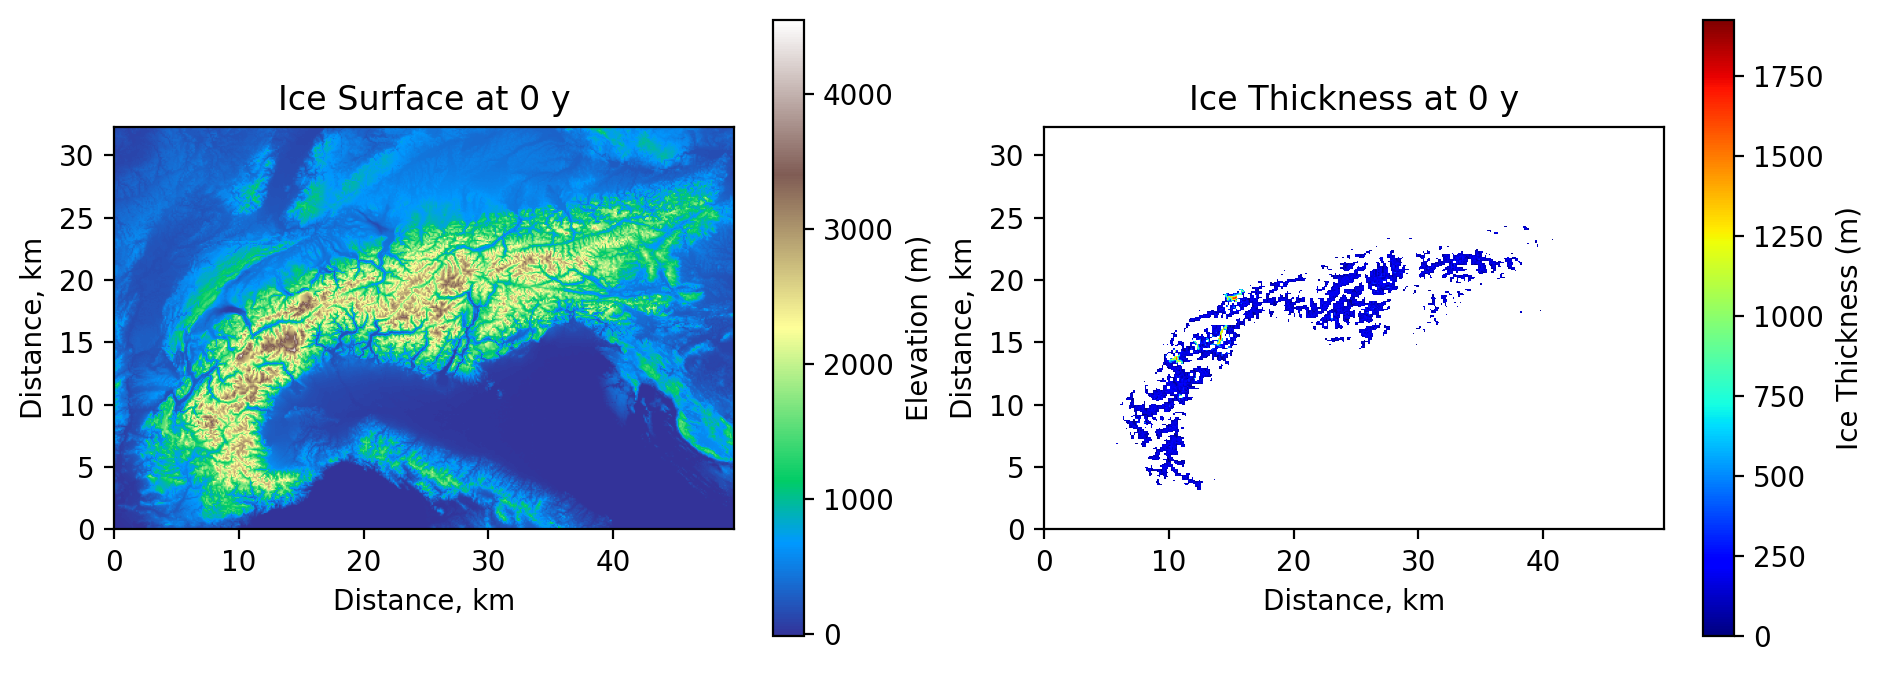

In [8]:
time =0
Lx=49700
Ly=32300
thicknes=h_32
Z_surf=Z_topo + thicknes
visualize(Z_surf,time,thicknes,Lx,Ly)


In [9]:
# Reset the starting point in tracking maximum GPU memory occupied by tensors in bytes for a given device.
torch.cuda.reset_peak_memory_stats()

# Initial guesses for inversion problem
Z_ELA = torch.full(Z_topo.shape, 2200.0, requires_grad=True, device=device)

# Observed glacier thickness (assumed already loaded as observed_thk tensor)
observed_thk = torch.load('Obs_2D.pt', weights_only=True).to(device,dtype=torch.float16)

# Define initial and final learning rates
initial_lr = 7
final_lr = 5
reg_lambda=0.000005
n_iterations = 3


# Optimizer setup
optimizer = torch.optim.Adam([Z_ELA], lr=initial_lr)

# Initialize lists to track loss components
total_loss_history = []
data_fidelity_history = []
regularization_history = []
total_gradients_history=[]
for i in range(n_iterations):
    # Update the learning rate
    lr = initial_lr - (i / (n_iterations - 1)) * (initial_lr - final_lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
    optimizer.zero_grad()  # Zero gradients

    # Perform forward simulation
    H_simulated, it= solve_glacier_dynamics(Z_topo, ttot, grad_b, b_max, Z_ELA)
    print(it)
    # Compute data fidelity term
    data_fidelity = torch.mean((H_simulated - observed_thk) ** 2)

    # Compute smoothness regularization
    smoothness_x = torch.sum((Z_ELA[:, 1:] - Z_ELA[:, :-1]) ** 2)
    smoothness_y = torch.sum((Z_ELA[1:, :] - Z_ELA[:-1, :]) ** 2)
    smoothness_reg = smoothness_x + smoothness_y

    # Total loss
    loss = data_fidelity + reg_lambda * smoothness_reg

    # Backpropagate loss and update parameters
    loss.backward()

    optimizer.step()

    # Store the gradients and ELA evolution
    total_gradients_history.append(torch.max(Z_ELA.grad).item())
    # Store loss components for plotting later
    total_loss_history.append(loss.item())
    data_fidelity_history.append(data_fidelity.item())
    regularization_history.append((reg_lambda * smoothness_reg).item())

    # Print loss and gradients every 50 iterations
    if (i + 1) % 1 == 0:
        print(f"\nIteration {i+1}/{n_iterations}, Loss: {loss:.3f}, ELA: {torch.mean(Z_ELA).item():.1f}")
        print_gpu_utilization()
        print_peak_gpu_memory()

537

Iteration 1/3, Loss: 1086.740, ELA: 2199.8
GPU memory occupied: 11599 MB.
Peak GPU memory used: 8585.70 MB.
539

Iteration 2/3, Loss: 1015.020, ELA: 2199.4
GPU memory occupied: 11617 MB.
Peak GPU memory used: 8599.62 MB.
543

Iteration 3/3, Loss: 955.069, ELA: 2199.0
GPU memory occupied: 11649 MB.
Peak GPU memory used: 8624.36 MB.


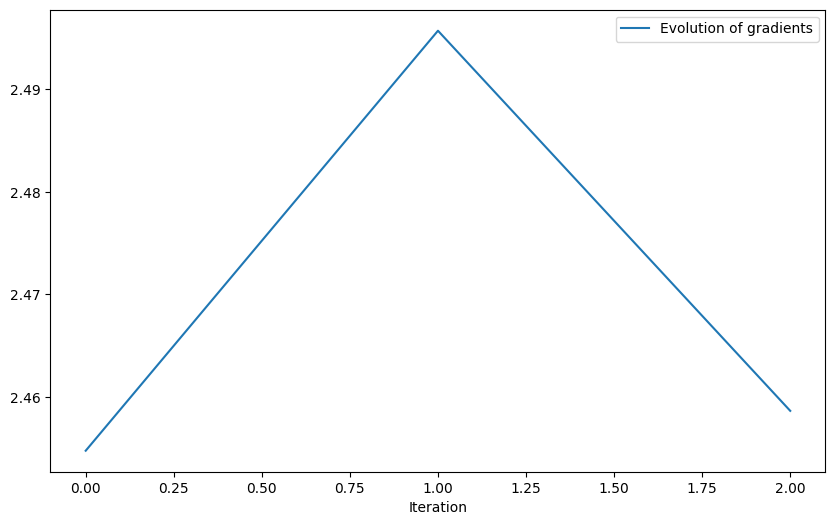

In [10]:
plt.figure(figsize=(10,6))
# plt.plot(ELA_evolution,label="evolution of ELA",color='b')
plt.plot(total_gradients_history, label='Evolution of gradients')
plt.xlabel('Iteration')
plt.legend()
plt.show()

In [11]:
# Function to plot the loss function components
def plot_loss_components(total_loss_history, data_fidelity_history, regularization_history):
    plt.figure(figsize=(10, 6))

    # Plot the total loss, data fidelity, and regularization term
    plt.plot(total_loss_history, label='Total Loss', color='b', linewidth=2)
    plt.plot(data_fidelity_history, label='Data Fidelity', color='g', linestyle='--', linewidth=2)
    plt.plot(regularization_history, label='Regularization (Smoothness)', color='r', linestyle='-.', linewidth=2)

    # Add labels and legend
    plt.xlabel('Iteration')
    plt.ylabel('Loss Value')
    plt.title('Loss Function Components Over Iterations')
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()

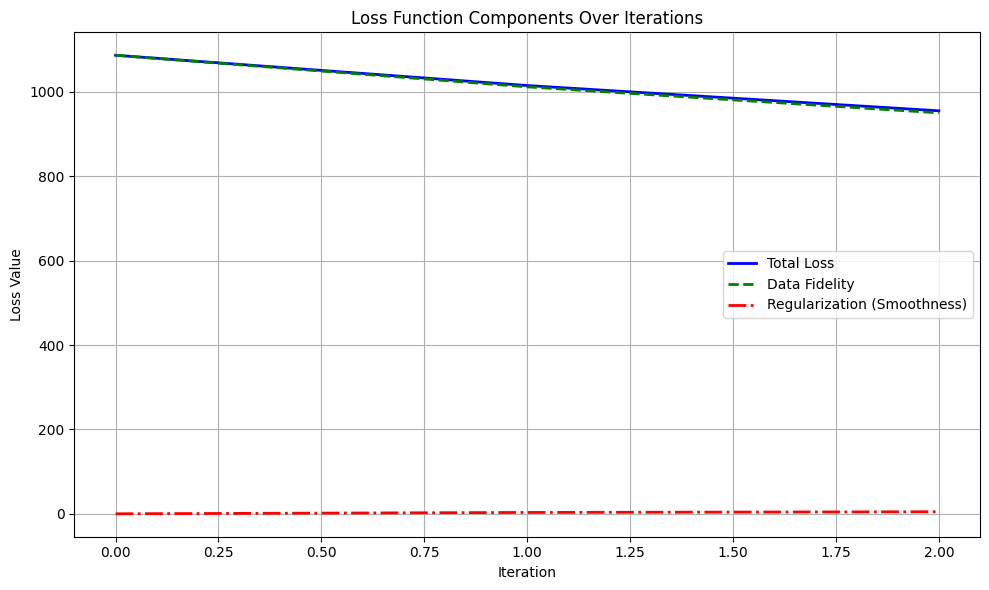

In [12]:
plot_loss_components(total_loss_history, data_fidelity_history, regularization_history)

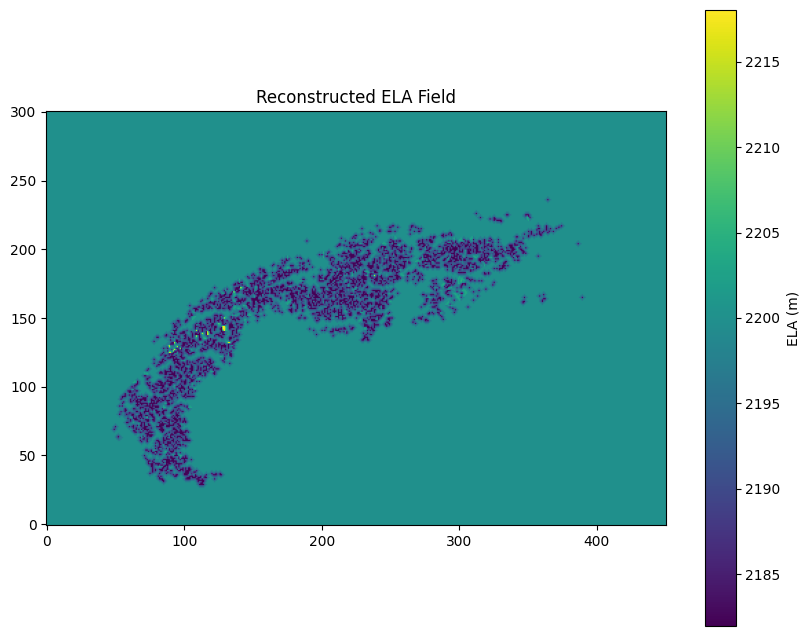

In [13]:
# Plot the ELA field
plt.figure(figsize=(10, 8))

# Convert Z_ELA to float32 for compatibility with NumPy
Z_ELA_np = Z_ELA.to(torch.float32).detach().cpu().numpy()

# Plot the field
plt.imshow(Z_ELA_np, cmap='viridis', origin='lower')
plt.colorbar(label='ELA (m)')
plt.title('Reconstructed ELA Field')
plt.show()


In [14]:
Z_ELA

tensor([[2200., 2200., 2200.,  ..., 2200., 2200., 2200.],
        [2200., 2200., 2200.,  ..., 2200., 2200., 2200.],
        [2200., 2200., 2200.,  ..., 2200., 2200., 2200.],
        ...,
        [2200., 2200., 2200.,  ..., 2200., 2200., 2200.],
        [2200., 2200., 2200.,  ..., 2200., 2200., 2200.],
        [2200., 2200., 2200.,  ..., 2200., 2200., 2200.]], device='cuda:0',
       requires_grad=True)